# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data.sampler import SubsetRandomSampler

The next three cells were used to separate the training data from the validation

In [ ]:
# !sudo apt install unzip
# !pip install split-folders

In [ ]:
# !unzip landmark_images.zip

In [ ]:
# import splitfolders
# splitfolders.ratio('landmark_images/train', output="landmark_images/dataset", seed=20, ratio=(.8, 0.2)) 

In [2]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to a normalized torch.FloatTensor
train_transform = transforms.Compose([
   
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_val_transform = transforms.Compose([
    
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_data = ImageFolder('landmark_images/dataset/train', transform=train_transform)
val_data = ImageFolder('landmark_images/dataset/val', transform=test_val_transform)
test_data = ImageFolder('landmark_images/test', transform=test_val_transform)

loaders_scratch = {
    
    
    'train': torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True), 
    
    'valid': torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True),
   
    'test': torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)}

classes = train_data.classes


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
Because the data for training and the valuation set was not separate, I separated it by separating the folders so that I could apply the data augmentation to the training data. I chose the image size to be 224 because the VGG16 accepts images of this size, so I want all models to be the same size to see the difference, as for the rest of the augmentation added to add more complexity to the trained data.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

In [3]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

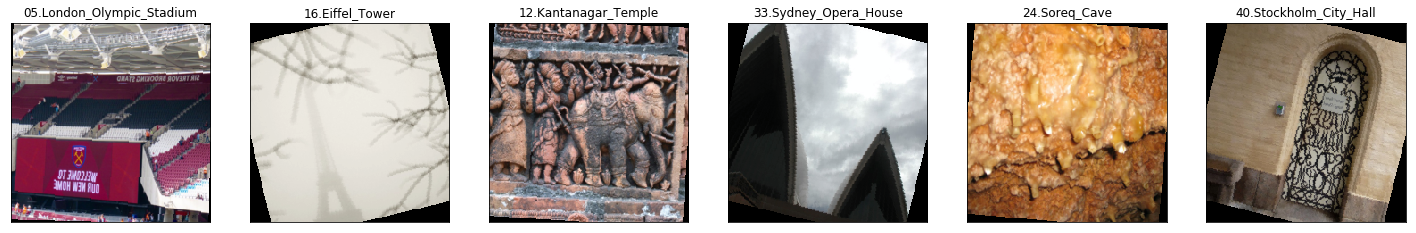

In [4]:
sample = next(iter(loaders_scratch['train']))
images, labels = sample
# display the images
fig = plt.figure(figsize=(25, 10))
# content and style ims side-by-side
for i in range(6):
    ax = fig.add_subplot(2, 6, i+1, xticks=[], yticks=[])
    ax.imshow(im_convert(images[i]))
    ax.set_title(classes[labels[i]])


### Initialize use_cuda variable

In [5]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [6]:
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    optimizer_scratch = optim.SGD(model.parameters(), lr=0.005)
    return optimizer_scratch

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [7]:
import torch.nn as nn

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN

        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)

        self.conv2 = nn.Conv2d(8, 64, 3, padding=1)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        
        self.fc1 = nn.Linear(512 * 7 * 7, 5000)
        
        self.fc2 = nn.Linear(5000, 2500)
       
        self.fc3 = nn.Linear(2500, 500)
      
        self.fc4 = nn.Linear(500, 133)
        
        self.fc5 = nn.Linear(133, 50)

        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        
        
        # flatten image input
        x = x.view(-1, 512 * 7 * 7)
        
        # fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [8]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 64, 11, stride=4, padding=2)
        
        self.conv2 = nn.Conv2d(64, 192, 5, padding=2)
       
        self.conv3 = nn.Conv2d(192, 256, 3, padding=2)
        
        self.conv4 = nn.Conv2d(256, 512, 3, padding=2)
       
        
        
        # max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        
        
        self.fc1 = nn.Linear(512 * 4 * 4, 5000)
        
        self.fc2 = nn.Linear(5000, 2500)
       
        self.fc3 = nn.Linear(2500, 500)
      
        self.fc4 = nn.Linear(500, 133)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        # batch normalization
        self.batn = nn.BatchNorm2d(192)
        self.batn2 = nn.BatchNorm2d(256)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batn(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.batn2(x)
        x = self.pool(F.relu(self.conv4(x)))
        
        
        # flatten image input
        x = x.view(-1, 512 * 4 * 4)
        
        # fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
The model consists of four layers of CNN interspersed with BatchNorm2d to avoid explosion or decay, followed by four Fully Connected layers, between each layer and the other a drop by 25% to avoid overfitting.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [9]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        
        if valid_loss < valid_loss_min:
                    torch.save(model.state_dict(), save_path)

                    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                    valid_loss_min,
                    valid_loss))

                    valid_loss_min = valid_loss
        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [10]:
def custom_weight_init(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

    
    

    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 4.321543 	Validation Loss: 3.831283
Validation loss decreased (inf --> 3.831283).  Saving model ...
Epoch: 2 	Training Loss: 3.774769 	Validation Loss: 3.554899
Validation loss decreased (3.831283 --> 3.554899).  Saving model ...
Epoch: 3 	Training Loss: 3.551690 	Validation Loss: 3.324891
Validation loss decreased (3.554899 --> 3.324891).  Saving model ...
Epoch: 4 	Training Loss: 3.359882 	Validation Loss: 3.171542
Validation loss decreased (3.324891 --> 3.171542).  Saving model ...
Epoch: 5 	Training Loss: 3.217883 	Validation Loss: 3.047679
Validation loss decreased (3.171542 --> 3.047679).  Saving model ...
Epoch: 6 	Training Loss: 3.079606 	Validation Loss: 2.913276
Validation loss decreased (3.047679 --> 2.913276).  Saving model ...
Epoch: 7 	Training Loss: 2.969545 	Validation Loss: 2.731812
Validation loss decreased (2.913276 --> 2.731812).  Saving model ...
Epoch: 8 	Training Loss: 2.844865 	Validation Loss: 2.630980
Validation loss decreased (2.73181

## Test the model with the Weight Initialization

In [11]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [12]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('ignore.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.159528


Test Accuracy: 45% (569/1250)


### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [13]:
## but changing it is not required
num_epochs = 25


# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.850686 	Validation Loss: 4.786623
Validation loss decreased (inf --> 4.786623).  Saving model ...
Epoch: 2 	Training Loss: 4.476787 	Validation Loss: 4.034549
Validation loss decreased (4.786623 --> 4.034549).  Saving model ...
Epoch: 3 	Training Loss: 3.994359 	Validation Loss: 3.947843
Validation loss decreased (4.034549 --> 3.947843).  Saving model ...
Epoch: 4 	Training Loss: 3.954749 	Validation Loss: 3.919712
Validation loss decreased (3.947843 --> 3.919712).  Saving model ...
Epoch: 5 	Training Loss: 3.916535 	Validation Loss: 3.869801
Validation loss decreased (3.919712 --> 3.869801).  Saving model ...
Epoch: 6 	Training Loss: 3.850346 	Validation Loss: 3.799182
Validation loss decreased (3.869801 --> 3.799182).  Saving model ...
Epoch: 7 	Training Loss: 3.788921 	Validation Loss: 3.711245
Validation loss decreased (3.799182 --> 3.711245).  Saving model ...
Epoch: 8 	Training Loss: 3.716152 	Validation Loss: 3.646214
Validation loss decreased (3.71124

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [14]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.711272


Test Accuracy: 30% (381/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [15]:
## Specify appropriate transforms, and batch_sizes

loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [24]:
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ptimizer_transfer =optim.SGD(model.classifier.parameters(), lr=0.005)
    return ptimizer_transfer


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [18]:
import torchvision.models as models
model_transfer = models.vgg16(pretrained=True)


# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

model_transfer.classifier[6] = last_layer



if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 109631395.65it/s]


In [20]:
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
As for the first model, I think it is suitable because it has several layers, which allows to extract more features, but it needs a lot of time to train to reach an acceptable score, but we can save time by useing VGG16 iit is a pre-trained before, so we see this big difference between the scores.

 

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [25]:

# train the model
n_epochs=30

model_transfer = train(n_epochs, loaders_transfer, model_transfer, 
                       get_optimizer_transfer(model_transfer), criterion_transfer, use_cuda, 'model_transfer.pt')



# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))


Epoch: 1 	Training Loss: 2.851711 	Validation Loss: 1.733936
Validation loss decreased (inf --> 1.733936).  Saving model ...
Epoch: 2 	Training Loss: 1.706407 	Validation Loss: 1.258693
Validation loss decreased (1.733936 --> 1.258693).  Saving model ...
Epoch: 3 	Training Loss: 1.397169 	Validation Loss: 1.054876
Validation loss decreased (1.258693 --> 1.054876).  Saving model ...
Epoch: 4 	Training Loss: 1.226514 	Validation Loss: 0.919797
Validation loss decreased (1.054876 --> 0.919797).  Saving model ...
Epoch: 5 	Training Loss: 1.106850 	Validation Loss: 0.815837
Validation loss decreased (0.919797 --> 0.815837).  Saving model ...
Epoch: 6 	Training Loss: 1.030311 	Validation Loss: 0.737649
Validation loss decreased (0.815837 --> 0.737649).  Saving model ...
Epoch: 7 	Training Loss: 0.946824 	Validation Loss: 0.668656
Validation loss decreased (0.737649 --> 0.668656).  Saving model ...
Epoch: 8 	Training Loss: 0.875953 	Validation Loss: 0.617565
Validation loss decreased (0.66865

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [26]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.819265


Test Accuracy: 78% (986/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [37]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
        # load the image and return the predicted breed
    img=Image.open(img_path)
    
    transform=transforms.Compose([ transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    #from image to tensor
    image_tensor = transform(img).float()
    #adds a dimension with a length of one
    image_ten = image_tensor.unsqueeze_(0)
    
    if use_cuda:
        img=image_ten.cuda()
        
    model_transfer.eval()  #evaluation mode 
    output = model_transfer(img)
    _, pred = torch.topk(output, k, dim=1, largest=True, sorted=True)

    return pred
    


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

tensor([[  9,  38,  30,  28,   3]], device='cuda:0')

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

In [64]:
class_names = [item[3:].replace("_", " ") for item in classes]

Is this picture of the 
Golden Gate Bridge, Forth Bridge,or Brooklyn Bridge ?


(None, <matplotlib.image.AxesImage at 0x7f68925662e8>)

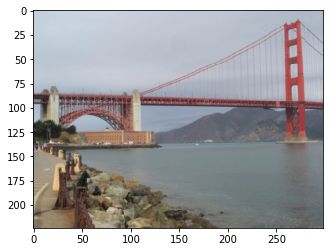

In [65]:
dataiter = iter(loaders_scratch['test'])
images, labels = dataiter.next()
images.numpy()
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
        
    in_transform = transforms.Compose([
                        transforms.Resize(224),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    image = plt.imshow(im_convert(image))
    location = print(f"Is this picture of the \n{class_names[predicted_landmarks[0][0]]}, {class_names[predicted_landmarks[0][1]]},or {class_names[predicted_landmarks[0][2]]} ?" )
    return location, image


    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
The model recognized the image of the Eagle Tower, although it is not in an ideal situation, but he did not recognize the rest because it is outside the classes he trained in.
Therefore, to develop it, I see that the number of classes should be increased, as well as training the model for a longer period and more data for each classes so that the model is trained in batches.



Is this picture of the 
Eiffel Tower, Sydney Harbour Bridge,or Monumento a la Revolucion ?


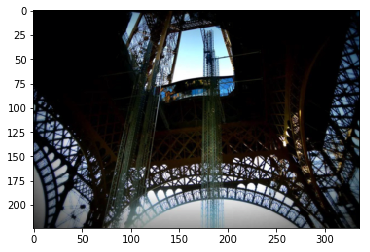

In [66]:
suggest_locations('suggest_locations/ezgif.com-gif-maker.jpg');

Is this picture of the 
Badlands National Park, Ljubljana Castle,or Death Valley National Park ?


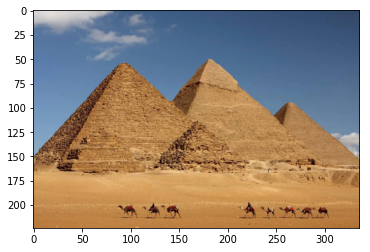

In [67]:
suggest_locations('suggest_locations/pyramids-of-giza-egypt.jpg.jpg');

Is this picture of the 
Whitby Abbey, Temple of Olympian Zeus,or Vienna City Hall ?


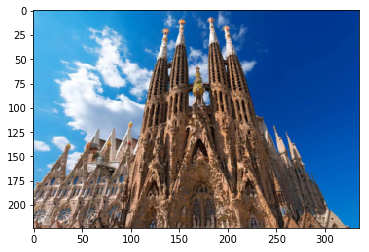

In [68]:
suggest_locations('suggest_locations/Temple-Expiatori-de-la-Sagrada-Familia-Barcelona-Spain.jpg.jpg');